In [1]:
import pandas as pd
import numpy as np
import random
import os

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [5]:
# 'Industry_Status',
# 'Hispanic_Origin',
# 'Household_Status',
# 'Birth_Country',
# 'Birth_Country (Father)', 
# 'Birth_Country (Mother)'

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [7]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

### modify education

<AxesSubplot:xlabel='Income', ylabel='Education_Status'>

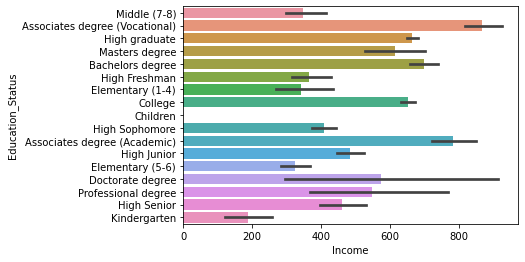

In [8]:
# g = train.groupby('Education_Status', as_index=False)['Income'].mean()
# plt.barh(g['Education_Status'], g['Income'],)

sns.barplot(x='Income', y='Education_Status', data=train, orient='h')

In [9]:
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [10]:
train['Education'] = train['Education_Status']
train['Education'] = train['Education'].apply(modify_education)

In [11]:
test['Education'] = test['Education_Status']
test['Education'] = test['Education'].apply(modify_education)

<AxesSubplot:xlabel='Income', ylabel='Education'>

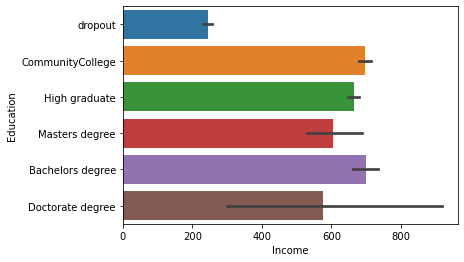

In [12]:
# g = train.groupby('Education', as_index=False)['Income'].mean()
# plt.barh(g['Education'], g['Income'],)

sns.barplot(x='Income', y='Education', data=train, orient='h')

### modify income status

<AxesSubplot:xlabel='Income', ylabel='Income_Status'>

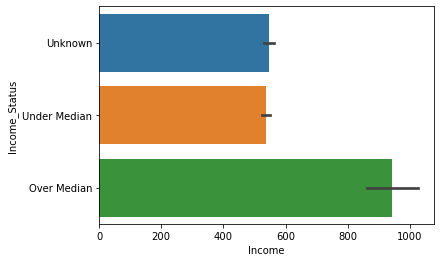

In [13]:
sns.barplot(x='Income', y='Income_Status', data=train, orient='h')

<AxesSubplot:xlabel='Income_Status', ylabel='Count'>

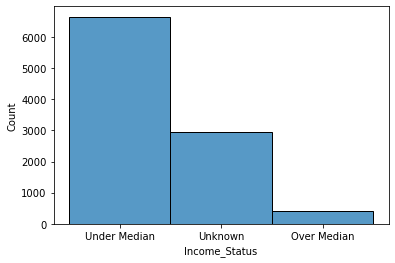

In [14]:
sns.histplot(test['Income_Status'])

In [15]:
def modify_income_status(status):
    if status in ['Unknown', 'Under Median']:
        return 'Under Median'
    else:
        return status

In [16]:
train['Income_Status'] = train['Income_Status'].apply(modify_income_status)
test['Income_Status'] = test['Income_Status'].apply(modify_income_status)

<AxesSubplot:xlabel='Income', ylabel='Income_Status'>

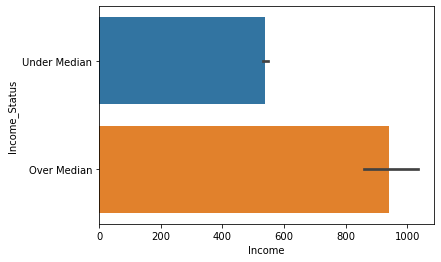

In [17]:
sns.barplot(x='Income', y='Income_Status', data=train, orient='h')

### continuous cols

In [18]:
numeric_cols = ['Age', 'Working_Week (Yearly)', 'Gains', 'Losses', 'Dividends', 'Income']

train_numeric = train[numeric_cols]

<AxesSubplot:>

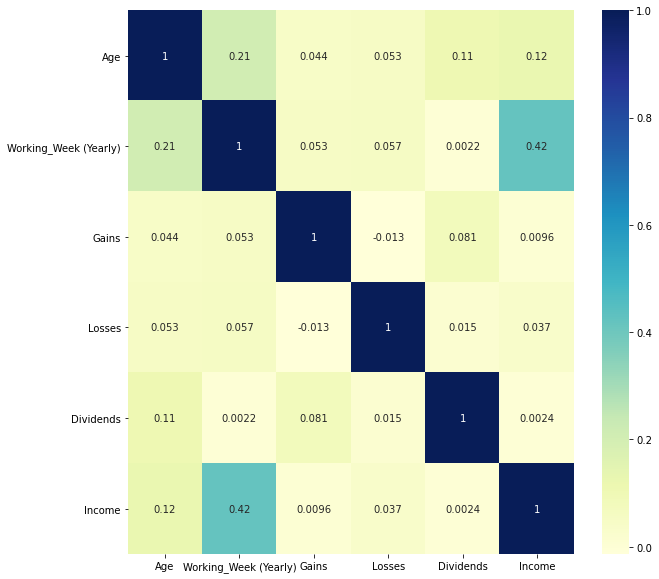

In [19]:
corr = train_numeric.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='YlGnBu', annot=True)

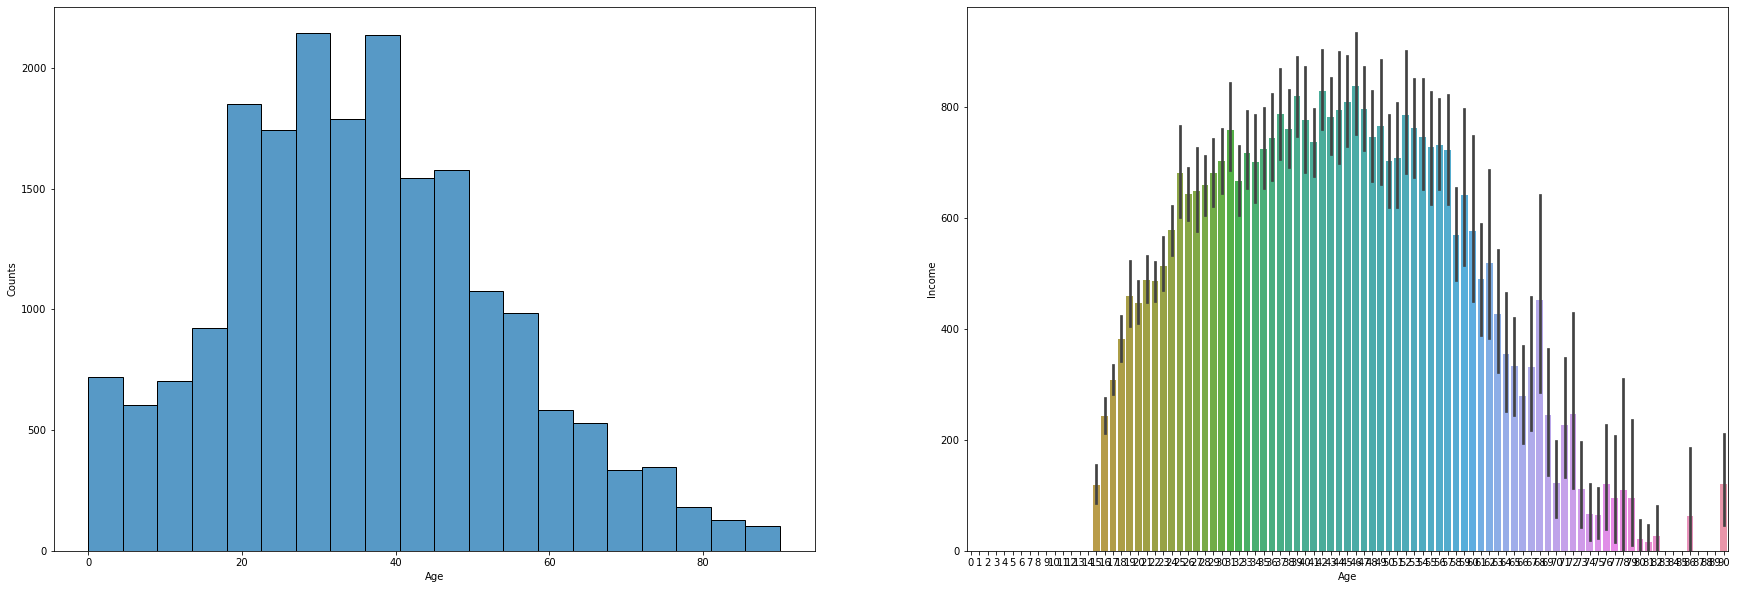

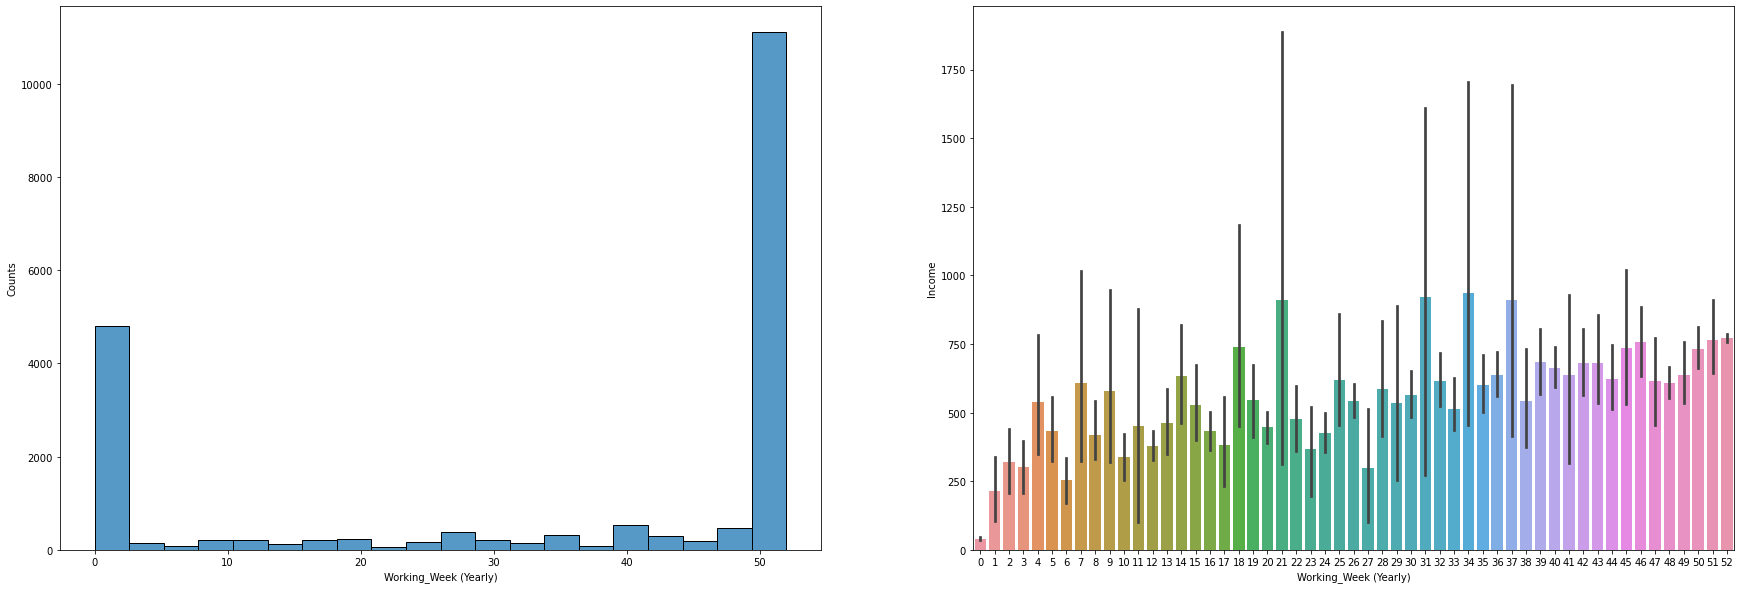

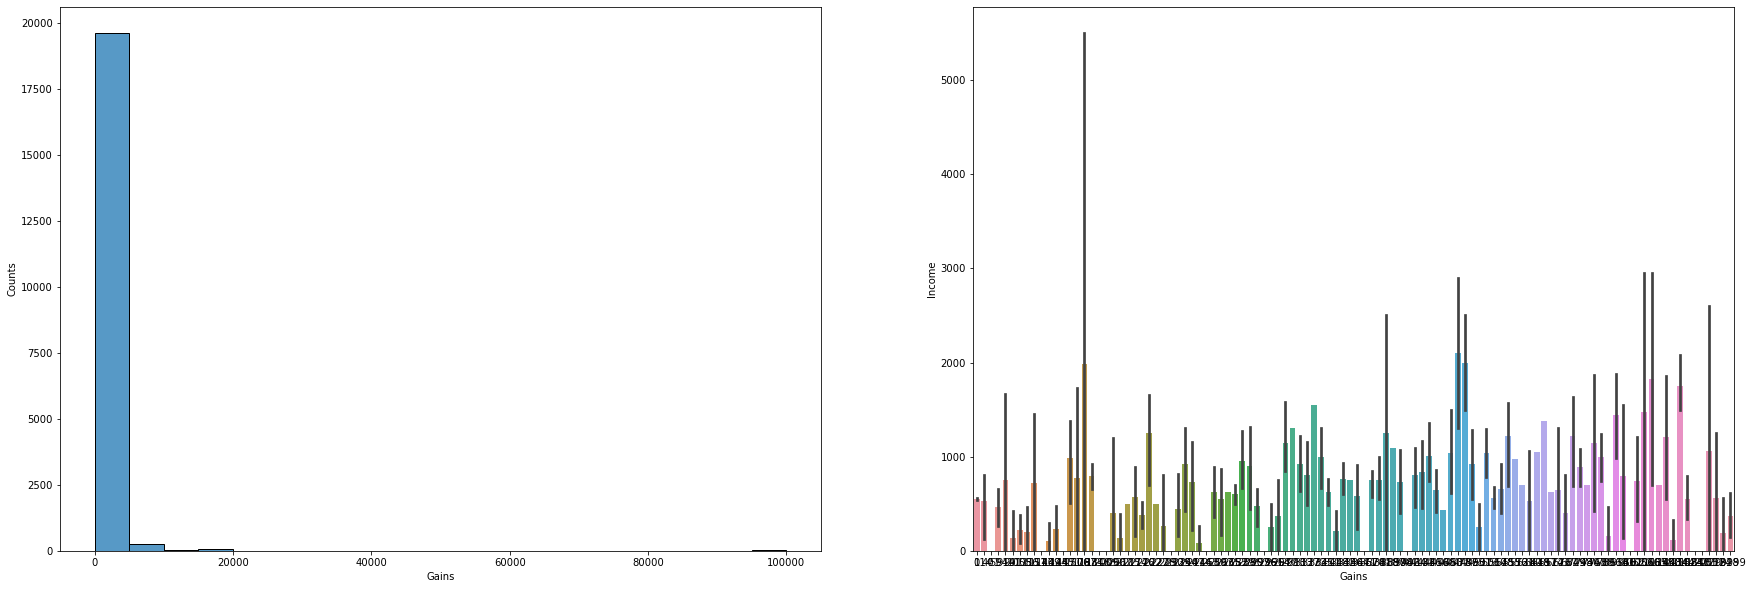

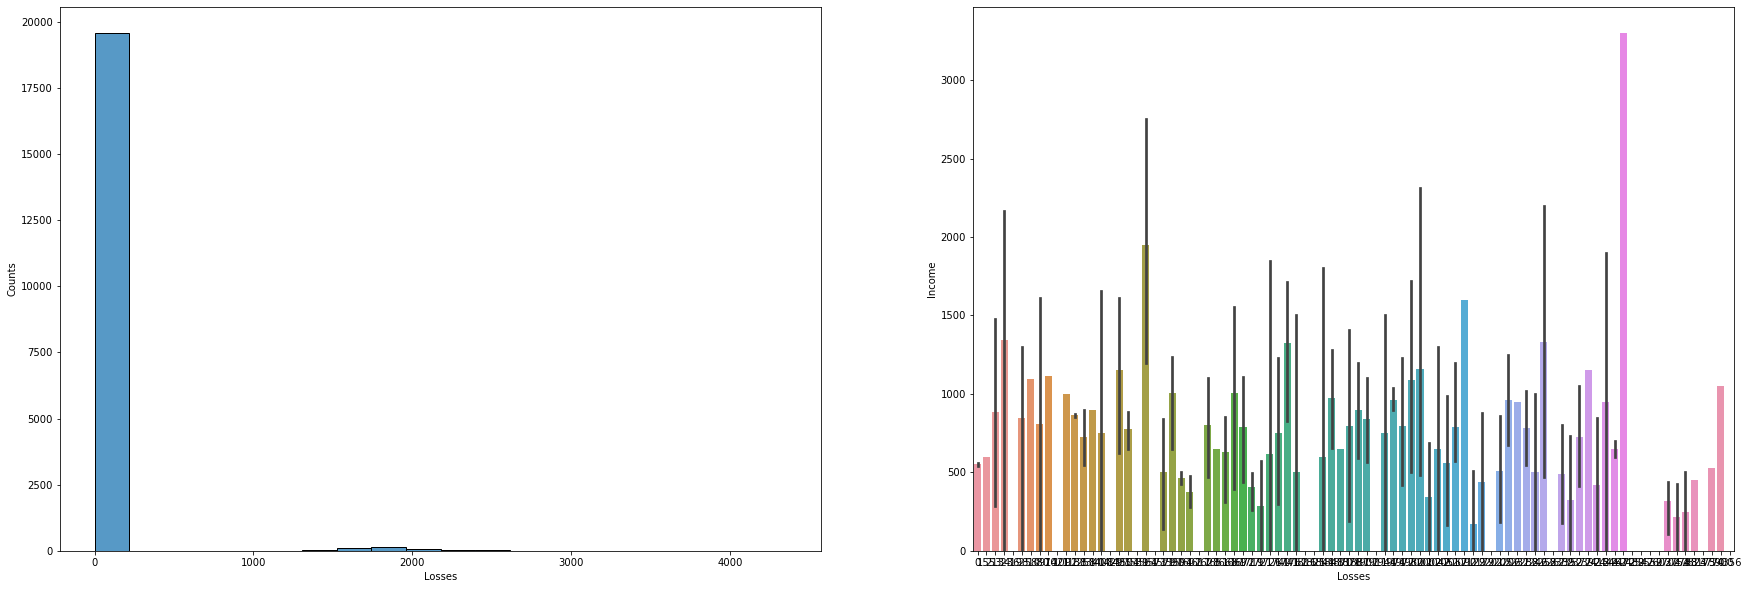

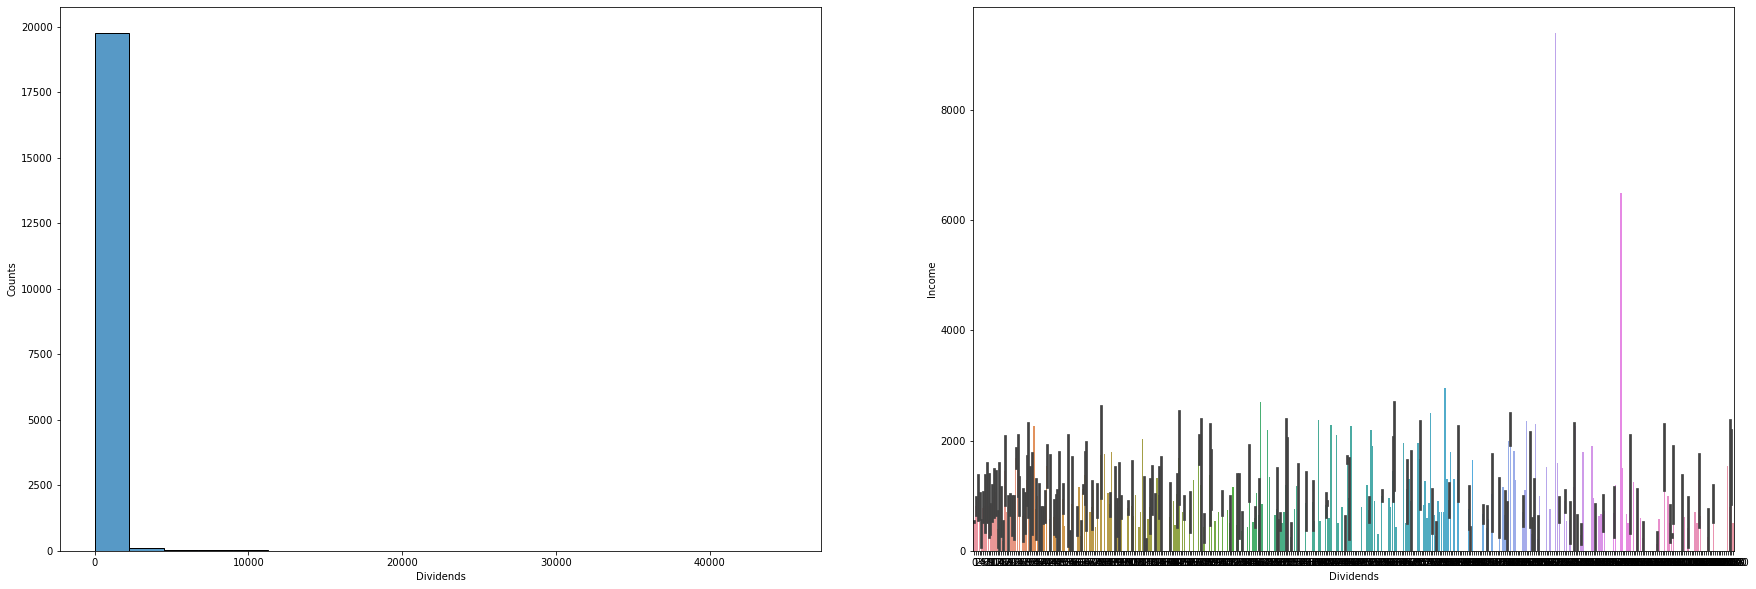

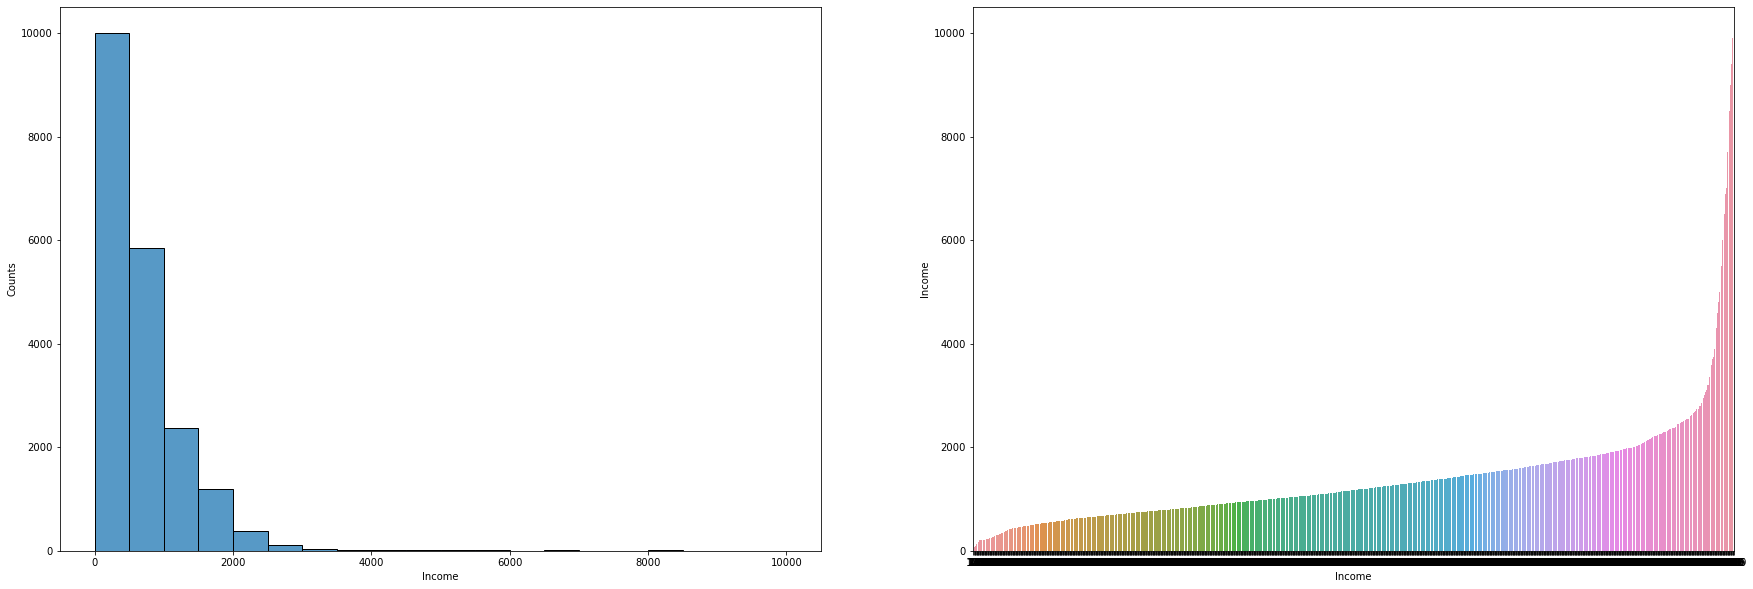

In [20]:
for c in numeric_cols:
    plt.figure(figsize=(30, 10))
    
    plt.subplot(1, 2, 1)
    sns.histplot(train[c], bins=20)
    plt.xlabel(c)
    plt.ylabel('Counts')

    plt.subplot(1, 2, 2)
    sns.barplot(x=c, y='Income', data=train)
    plt.xlabel(c)
    plt.ylabel('Income')

    plt.show()

### main

In [21]:
trainval_x = train.drop(columns=['ID', 'Income', 
                                #  'Industry_Status',
                                 'Hispanic_Origin', 
                                 'Household_Status', 
                                 'Birth_Country', 
                                 'Birth_Country (Father)', 'Birth_Country (Mother)',
                                 'Education_Status',
                                #  'Gains', 'Losses', 'Dividends'
                                 ])
trainval_y = train['Income']

test_x = test.drop(columns=['ID',
                            # 'Industry_Status',
                            'Hispanic_Origin', 
                            'Household_Status', 
                            'Birth_Country', 
                            'Birth_Country (Father)', 'Birth_Country (Mother)',
                            'Education_Status',
                            # 'Gains', 'Losses', 'Dividends'
                            ])

In [22]:
trainval_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    20000 non-null  int64 
 1   Gender                 20000 non-null  object
 2   Employment_Status      20000 non-null  object
 3   Working_Week (Yearly)  20000 non-null  int64 
 4   Industry_Status        20000 non-null  object
 5   Occupation_Status      20000 non-null  object
 6   Race                   20000 non-null  object
 7   Martial_Status         20000 non-null  object
 8   Household_Summary      20000 non-null  object
 9   Citizenship            20000 non-null  object
 10  Tax_Status             20000 non-null  object
 11  Gains                  20000 non-null  int64 
 12  Losses                 20000 non-null  int64 
 13  Dividends              20000 non-null  int64 
 14  Income_Status          20000 non-null  object
 15  Education          

In [23]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

for i in encoding_target:
    le = LabelEncoder()
    
    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)
    
    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            print('case')
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

    # encoder = OneHotEncoder(categories='auto', sparse=False)
    # trainval_x_encoded = encoder.fit_transform(trainval_x[i].values.reshape(-1, 1))
    # test_x_encoded = encoder.transform(test_x[i].values.reshape(-1, 1))
    
    # # 새로운 열 추가
    # for j, cat in enumerate(encoder.categories_[0]):
    #     trainval_x[f"{i}_{cat}"] = trainval_x_encoded[:, j]
    #     test_x[f"{i}_{cat}"] = test_x_encoded[:, j]
    
    # # 기존 열 제거
    # trainval_x.drop(columns=i, inplace=True)
    # test_x.drop(columns=i, inplace=True)

In [24]:
# trainval_x.columns

In [25]:
# numeric_cols = ['Age', 'Working_Week (Yearly)', 'Gains', 'Losses', 'Dividends']

# scaler_x = StandardScaler()

# trainval_x[numeric_cols] = scaler_x.fit_transform(trainval_x[numeric_cols])
# test_x[numeric_cols] = scaler_x.transform(test_x[numeric_cols])

In [26]:
kf = KFold(n_splits=5)

In [27]:
num_fold = 1
total_train_error, total_val_error = 0, 0
test_preds = []
for train_idx, val_idx in kf.split(np.arange(len(trainval_x))):
    train_x = trainval_x.iloc[train_idx]
    train_y = trainval_y.iloc[train_idx]

    val_x = trainval_x.iloc[val_idx]
    val_y = trainval_y.iloc[val_idx]

    model = GradientBoostingRegressor(max_depth=7)
    model.fit(train_x, train_y)

    print(f'{num_fold} fold')

    train_y_hat = model.predict(train_x)
    val_y_hat = model.predict(val_x)

    pred = model.predict(test_x)
    test_preds.append(pred)

    train_error = mean_squared_error(train_y, train_y_hat) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat) ** 0.5

    total_train_error += train_error
    total_val_error += val_error

    print(f'train error : {train_error:.2f}')
    print(f'val error : {val_error:.2f}')
    
    print('-'*30)

    # feat_importance = model.feature_importances_
    # importance_df = pd.Series(feat_importance, index=train_x.columns)
    # importance_df.sort_values(inplace=True)

    # plt.figure(figsize=(12,12))
    # plt.rc('font', size=12)
    # plt.barh(np.arange(len(importance_df)), importance_df)
    # plt.yticks(np.arange(len(importance_df)), importance_df.index)
    # plt.show()

    num_fold += 1

1 fold
train error : 444.62
val error : 657.48
------------------------------
2 fold
train error : 455.82
val error : 622.36
------------------------------
3 fold
train error : 464.99
val error : 609.16
------------------------------
4 fold
train error : 464.77
val error : 565.73
------------------------------
5 fold
train error : 465.17
val error : 587.34
------------------------------


In [28]:
print(f'final train error : {total_train_error/5:.2f}')
print(f'final val error : {total_val_error/5:.2f}')

final train error : 459.07
final val error : 608.42


### modify education
##### final train error : 456.20
##### final val error : 610.15

### modify income status 1
##### final train error : 459.07
##### final val error : 608.42

In [29]:
final_pred = np.array(test_preds).mean(0)

In [30]:
submission = pd.read_csv('data/sample_submission.csv')
submission

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
9995,TEST_9995,0
9996,TEST_9996,0
9997,TEST_9997,0
9998,TEST_9998,0


In [31]:
submission['Income'] = final_pred
submission

,ID,Income
0,TEST_0000,-1.367361
1,TEST_0001,31.340819
2,TEST_0002,407.449383
3,TEST_0003,621.593877
4,TEST_0004,3.033274
...,...,...
9995,TEST_9995,909.235724
9996,TEST_9996,817.979346
9997,TEST_9997,381.699638
9998,TEST_9998,3.033274


In [32]:
os.makedirs('submission', exist_ok=True)
# submission.to_csv('submission/baseline_0314.csv', index=False)
submission.to_csv('submission/feat_engineering_0319_1.csv', index=False)